In [36]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Dimensions of the bipolar image: (245, 245)


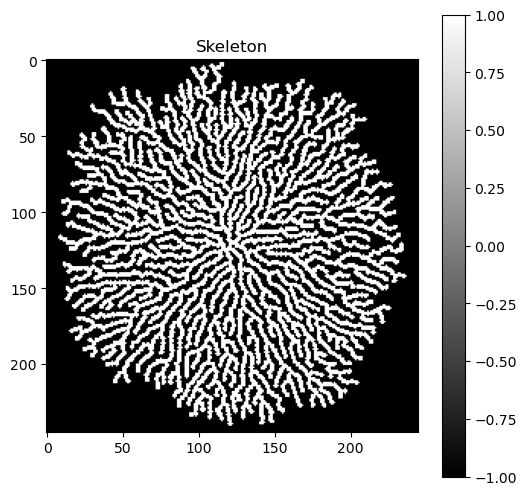

In [37]:
import numpy as np
import matplotlib.image as mpimg

# Step 1: Load the RGB image
image_path = os.getcwd() + "\\Mycelium_model_real_image.png"
rgb_image = mpimg.imread(image_path)

# Step 2: Use only the first channel for simplicity
first_channel = rgb_image[:, :, 0]  # Extract the first channel
threshold = 0.5
skeleton = np.where(first_channel < threshold, 1, -1)  # Create bipolar image directly

# Step 3: Extract dimensions
dimensions = skeleton.shape
print(f"Dimensions of the bipolar image: {dimensions}")

# Step 4: Plot the bipolar image
plt.figure(figsize=(6, 6))
plt.title('Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.colorbar()
plt.show()


In [38]:
# Hyperparameters
grid_size = skeleton.shape[0]
total_iterations = 500

In [39]:
import torch
import numpy as np

def export_tensor_to_csv_numpy(tensor, filename):
    if device == 'cuda':
        array = tensor.detach().cpu().numpy()
    else:
        array = tensor.cpu().numpy()
    
    # Ensure the array is of floating-point type
    if not np.issubdtype(array.dtype, np.floating):
        array = array.astype(np.float64)
    
    # Save with double precision and '.' as decimal delimiter
    np.savetxt(filename, array, delimiter=',', fmt='%.15f')
    print(f"Exported tensor to {filename} using NumPy with double precision.")

In [40]:
import os

output_dir = os.getcwd() + "\\skeleton2Outputs"
os.makedirs(output_dir, exist_ok=True)

In [41]:
# Reaction-Diffusion parameters
pa = 0.5
pb = 0.8
pc = 0.16
pe = 2.6
d = 30
dt = 1e-1
threshold = 0.5
pk = 0.05
gamma = 625
ph = 1
alpha = 1
amax = 100
smax = 35
substrate_val = 0.3

122
(245, 245)
torch.Size([245, 245])
torch.Size([245, 245])
torch.Size([245, 245])


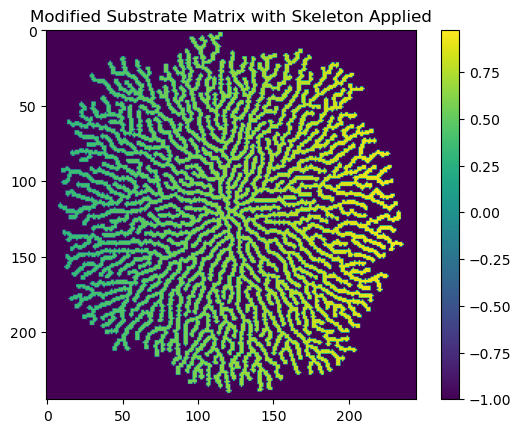

In [42]:
# Initialize activator, suppressor, and mycelium matrices as PyTorch tensors
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

u_new = torch.zeros_like(u)
v_new = torch.zeros_like(v)
c_new = torch.zeros_like(c)

# Initialize nutrient landscape
mid = grid_size // 2

n = np.linspace(substrate_val, 1, grid_size)
n = np.tile(n, (grid_size, 1))

# Step 2: Apply the skeleton mask
n[skeleton < 0] = -1
print(mid)

print(n.shape)
print(u.shape)
print(v.shape)
print(c.shape)

plt.imshow(n, cmap='viridis')  # Using viridis for better color distinction
plt.colorbar()
plt.title("Modified Substrate Matrix with Skeleton Applied")
plt.show()

n = torch.tensor(n, dtype=torch.float32, device=device)

In [43]:
# Initialize matrices
u = torch.zeros((grid_size, grid_size), device=device)
v = torch.zeros((grid_size, grid_size), device=device)
c = torch.zeros((grid_size, grid_size), device=device)

# Initial activator and suppressor states
for k in range(-6, 5):  # This ranges from -5 to 5, inclusive
    size = 2 * abs(k) + 1  # This computes the size of the square
    start_idx = mid + k if k < 0 else mid - k
    if start_idx + size <= grid_size:  # Check to ensure indices are within bounds
        random_tensor = torch.rand((size, size), device=device) * 0.5 
        # u[start_idx:start_idx+size, start_idx:start_idx+size] = 0.5 + random_tensor / (0.5 * n[start_idx:start_idx+size, start_idx:start_idx+size])
        # v[start_idx:start_idx+size, start_idx:start_idx+size] = 0.1 + random_tensor / (0.5 * n[start_idx:start_idx+size, start_idx:start_idx+size])
        # c[start_idx:start_idx+size, start_idx:start_idx+size] = 1
        u[start_idx:start_idx+size, start_idx:start_idx+size] = 0.5 + 0.2
        v[start_idx:start_idx+size, start_idx:start_idx+size] = 0.1 + 0.2 
        c[start_idx:start_idx+size, start_idx:start_idx+size] = 1

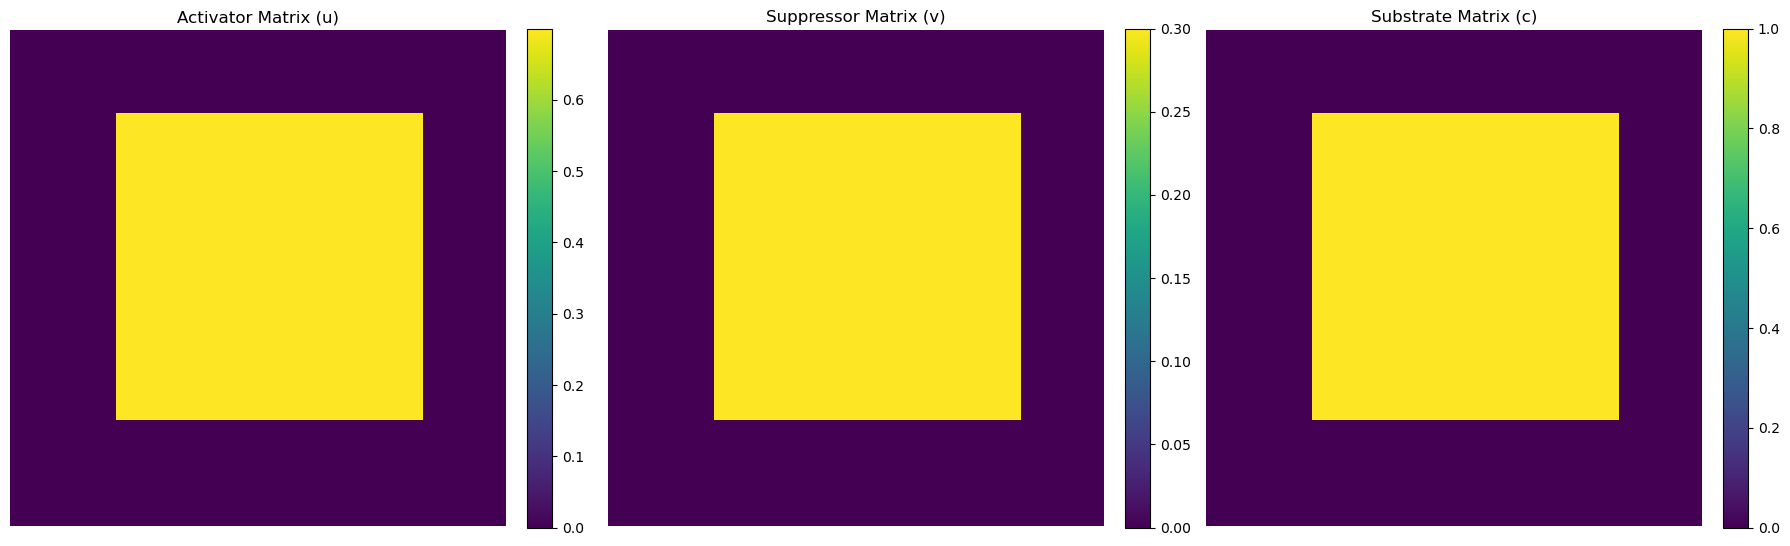

In [44]:
import matplotlib.pyplot as plt

# Assuming 'u', 'v', and 'c' are PyTorch tensors and have been processed appropriately.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Wider figure to accommodate colorbars

# Define limits for zooming into the center
x_limits = (mid-11, mid+10)
y_limits = (mid-11, mid+10)

# Plot u matrix
im_u = axs[0].imshow(u.cpu().numpy(), cmap='viridis')
axs[0].set_title('Activator Matrix (u)')
axs[0].axis('off')
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
fig.colorbar(im_u, ax=axs[0], fraction=0.046, pad=0.04)  # Add colorbar to the plot of u

# Plot v matrix
im_v = axs[1].imshow(v.cpu().numpy(), cmap='viridis')
axs[1].set_title('Suppressor Matrix (v)')
axs[1].axis('off')
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
fig.colorbar(im_v, ax=axs[1], fraction=0.046, pad=0.04)  # Add colorbar to the plot of v

# Plot c matrix
im_c = axs[2].imshow(c.cpu().numpy(), cmap='viridis')
axs[2].set_title('Substrate Matrix (c)')
axs[2].axis('off')
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
fig.colorbar(im_c, ax=axs[2], fraction=0.046, pad=0.04)  # Add colorbar to the plot of c

plt.tight_layout()
plt.show()


In [45]:
# Define filenames with step number
filename_c = os.path.join(output_dir, f'c_init.csv')
filename_u = os.path.join(output_dir, f'u_init.csv')
filename_v = os.path.join(output_dir, f'v_init.csv')
filename_n = os.path.join(output_dir, f'n_init.csv')

# Export tensors to CSV using NumPy
export_tensor_to_csv_numpy(c, filename_c)
export_tensor_to_csv_numpy(u, filename_u)
export_tensor_to_csv_numpy(v, filename_v)
export_tensor_to_csv_numpy(n, filename_n)

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_init.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_init.csv using NumPy with double precision.


In [46]:
def update_visualization(step, u, v, c, n):
    fig = plt.figure(figsize=(7, 7))
    
    # Activator u
    ax1 = fig.add_subplot(221)
    img1 = ax1.imshow(u.cpu().numpy(), cmap='jet', vmin=0, vmax=amax)
    ax1.set_title(f'Activator u at iteration {step}')
    fig.colorbar(img1, ax=ax1)  # Add colorbar for this subplot

    # Suppressor v
    ax2 = fig.add_subplot(222)
    img2 = ax2.imshow(v.cpu().numpy(), cmap='jet', vmin=0, vmax=smax)
    ax2.set_title(f'Suppressor v at iteration {step}')
    fig.colorbar(img2, ax=ax2)  # Add colorbar for this subplot

    # Mycelium c
    ax3 = fig.add_subplot(223)
    img3 = ax3.imshow(c.cpu().numpy(), cmap='jet', vmin=-1, vmax=1)
    ax3.set_title(f'Mycelium at iteration {step}')
    fig.colorbar(img3, ax=ax3)  # Add colorbar for this subplot

    # Substrate n
    ax4 = fig.add_subplot(224)
    img4 = ax4.imshow(n.cpu().numpy(), cmap='jet')
    ax4.set_title('Substrate')
    fig.colorbar(img4, ax=ax4)  # Add colorbar for this subplot

    plt.tight_layout()
    plt.show()

In [47]:
# Laplacian (Diffusion) Kernel Weights
lap_side = 0.35
lap_diag = 0.1
lap = 1/9

# Depth (Size) of Kernel
depth = 2

# Plasma Membrane of Mycelium
ij_mat = torch.zeros((grid_size, grid_size), device=device)

In [48]:
# # Pre-calculate the Laplacian kernel indices and weights if they remain constant
lap_kernel = torch.zeros((2*depth+1, 2*depth+1), device=device)
for dx in range(-depth, depth + 1):
    for dy in range(-depth, depth + 1):
        if dx == 0 and dy == 0:
            lap_kernel[depth, depth] = lap
        elif abs(dx) == abs(dy):
            lap_kernel[depth + dx, depth + dy] = lap_diag
        else:
            lap_kernel[depth + dx, depth + dy] = lap_side

print(lap_kernel)
print(lap_kernel.shape)

repeat_factor = grid_size // 5
D = lap_kernel.repeat(repeat_factor, repeat_factor)


print(f"D shape: {D.shape}")  # Should be (grid_size, grid_size)

tensor([[0.1000, 0.3500, 0.3500, 0.3500, 0.1000],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.3500, 0.3500, 0.1111, 0.3500, 0.3500],
        [0.3500, 0.1000, 0.3500, 0.1000, 0.3500],
        [0.1000, 0.3500, 0.3500, 0.3500, 0.1000]], device='cuda:0')
torch.Size([5, 5])
D shape: torch.Size([245, 245])


In [49]:
# Define the 3x3 Laplacian kernel L
L = torch.tensor([
    [lap_diag, lap_side, lap_diag],
    [lap_side, -lap,     lap_side],
    [lap_diag, lap_side, lap_diag]
], dtype=torch.float32, device=device)

print(L)

tensor([[ 0.1000,  0.3500,  0.1000],
        [ 0.3500, -0.1111,  0.3500],
        [ 0.1000,  0.3500,  0.1000]], device='cuda:0')


In [50]:
import torch.nn.functional as F

def conv2_same(input_tensor, kernel):
    """
    Performs a 2D convolution with 'same' padding.
    
    Args:
        input_tensor (torch.Tensor): Input tensor of shape [H, W].
        kernel (torch.Tensor): Convolution kernel of shape [kH, kW] or [1, 1, kH, kW].
    
    Returns:
        torch.Tensor: Convolved tensor of shape [H, W].
    """
    # Ensure the kernel has 4 dimensions
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, kH, kW]
    elif kernel.dim() == 4:
        pass  # Already in the correct shape
    else:
        raise ValueError("Kernel must be a 2D or 4D tensor.")
    
    # Extract kernel dimensions
    _, _, kH, kW = kernel.shape
    
    # Calculate padding for 'same' convolution
    pad_h = (kH - 1) // 2
    pad_w = (kW - 1) // 2
    
    # Reshape input to [N, C, H, W]
    input_reshaped = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # Perform convolution with calculated padding
    conv_result = F.conv2d(input_reshaped, kernel, padding=(pad_h, pad_w))
    
    # Reshape back to [H, W]
    return conv_result.squeeze(0).squeeze(0)

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_step_0.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_step_0.csv using NumPy with double precision.


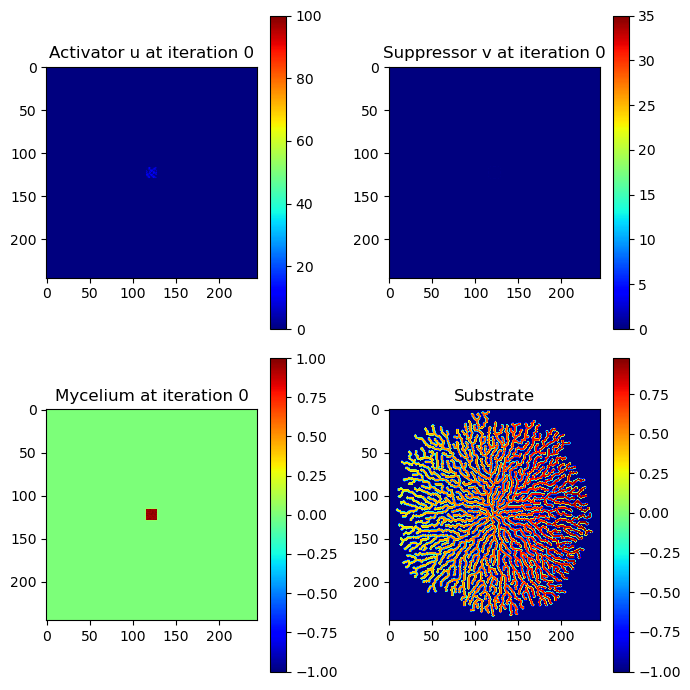

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_step_100.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_step_100.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_step_100.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_step_100.csv using NumPy with double precision.


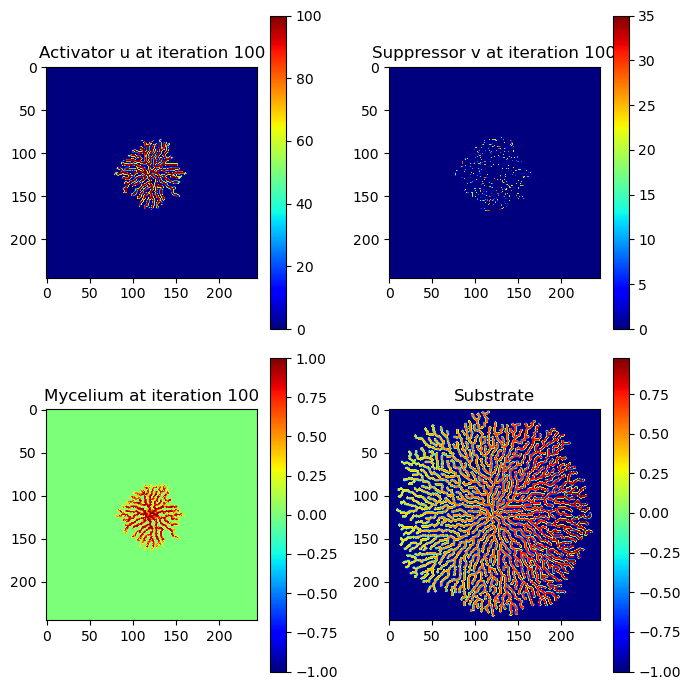

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_step_200.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_step_200.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_step_200.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_step_200.csv using NumPy with double precision.


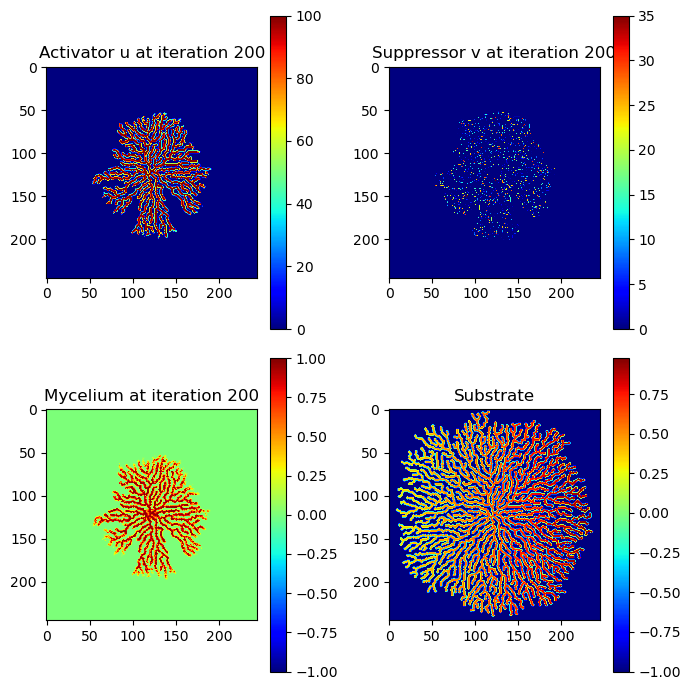

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_step_300.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_step_300.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_step_300.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_step_300.csv using NumPy with double precision.


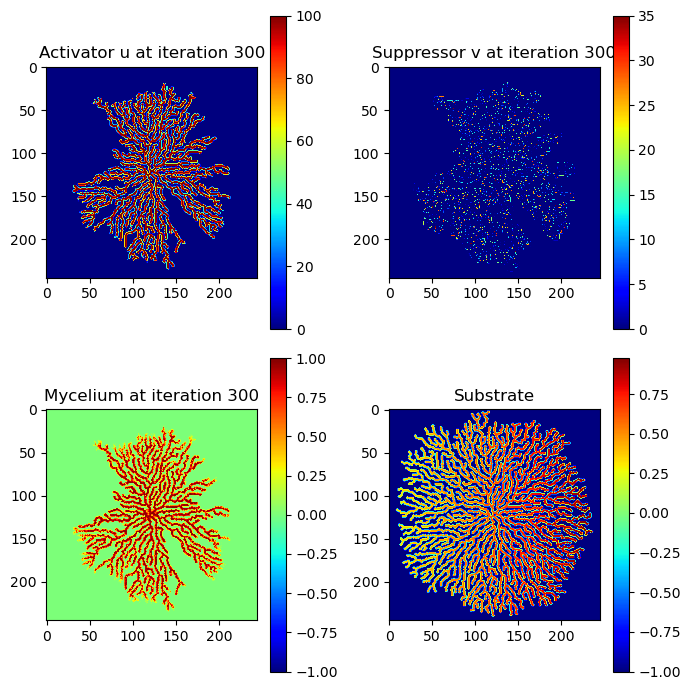

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_step_400.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_step_400.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_step_400.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_step_400.csv using NumPy with double precision.


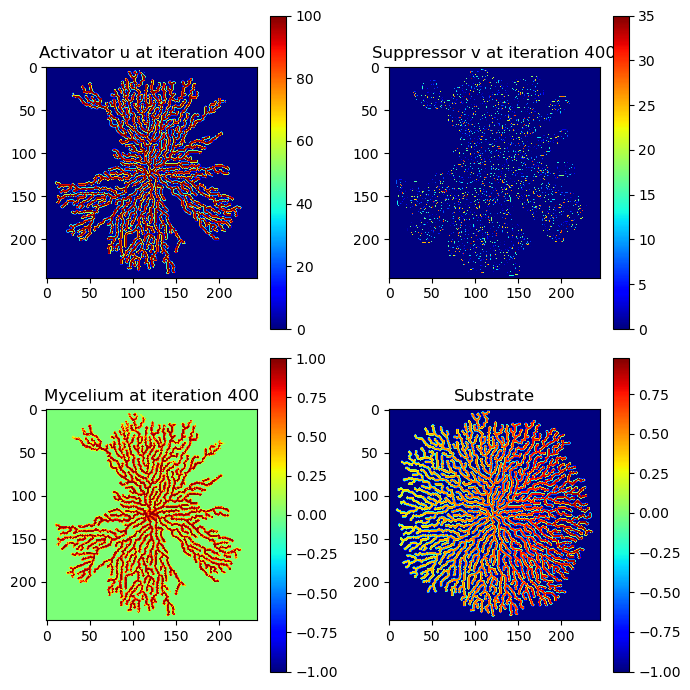

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\c_step_500.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\u_step_500.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\v_step_500.csv using NumPy with double precision.
Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\n_step_500.csv using NumPy with double precision.


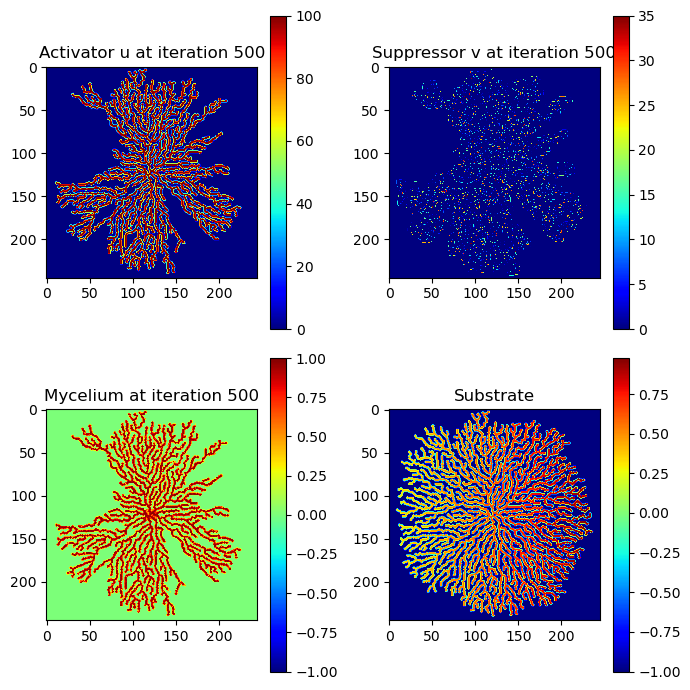

In [51]:
import torch
import torch.nn.functional as F

# Generate a random integer between 1 and 10, and divide by 10000
noise_u = torch.randint(1, 11, u.size(), device=device).float() / 10000
noise_c = torch.randint(1, 1001, c.size(), device=device).float() / 10000

ones_kernel = torch.ones((1, 1, lap_kernel.shape[0], lap_kernel.shape[1]), dtype=torch.float32, device=device)

# Main simulation loop
for step in range(total_iterations + 1):
    # Reaction Terms
    f_uv = (pa * u + u ** 2 - pb * u * v) * n
    g_uv = pe * u ** 3 - v

    # Calculate ij_mat - the plasma membrane in which the mycelium can expand each iteration
    c_positive = (c > 0).float()

    input_tensor = c_positive.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, gridSize, gridSize]

    conv_result = F.conv2d(input_tensor, ones_kernel, padding=depth)
    conv_result = conv_result.squeeze(0).squeeze(0)  # Shape: [gridSize, gridSize]
    
    # conv_min = torch.min(conv_result, 1)
    conv_min = torch.minimum(conv_result, torch.ones_like(conv_result))    

    ij_mat = conv_min * D

    # Compute v_new and u_new
    conv_v = conv2_same(v, L)  
    term_v = d * conv_v + gamma * g_uv 
    update_v = ij_mat * term_v 
    v_new = v + dt * update_v

    conv_u = conv2_same(u, L)
    term_u = conv_u + gamma * f_uv 
    update_u = ij_mat * term_u
    u_new = u + dt * update_u 

    # # Create c_positive where c > 0 is set to 1, else 0
    # c_positive = (c > 0).float()

    # # Perform convolution of c_positive with ones_kernel to compute ij_mat
    # # 'same' padding is handled by the conv2_same function
    # conv_c = F.conv2d(c_positive.unsqueeze(0).unsqueeze(0), ones_kernel, padding=2)
    # conv_c = conv_c.squeeze(0).squeeze(0)  # Shape: [grid_size, grid_size]

    # # Apply element-wise minimum with 1
    # conv_min = torch.clamp(conv_c, max=1.0)

    # # Compute ij_mat
    # ij_mat = conv_min * D

    # # Compute v_new
    # conv_v = conv2_same(v, L)  # Shape: [H, W]
    # term_v = d * conv_v + gamma * g_uv  # Shape: [H, W]
    # update_v = ij_mat * term_v  # Shape: [H, W]
    # v_new = v + dt * update_v  # Shape: [H, W]

    # # Compute u_new
    # conv_u = conv2_same(u, L)  # Shape: [H, W]
    # term_u = conv_u + gamma * f_uv  # Shape: [H, W]
    # update_u = ij_mat * term_u  # Shape: [H, W]
    # u_new = u + dt * update_u  # Shape: [H, W]


    # Apply threshold and adjust alpha
    u_new = torch.where(n == -1, u - noise_u, u_new)
    alpha = torch.where(u <= threshold, 0.49, 0.49 - 2.5 * (u - threshold))
    v_new = torch.where(u <= threshold, v_new, 0)

    # Update c using alpha and apply limits
    c_new = c + dt * gamma * ph * c * (alpha - c) * (c - 1)
    c_new = torch.where(alpha < 0, c + noise_c, c_new)

    # Limiters of activator and suppressor to avoid exponential growth
    u_new = torch.clamp(u_new, min=0, max=amax)
    v_new = torch.where(v_new > smax, smax, v_new)
    c_new = torch.where(c_new > 1, 1, c_new)
    c_new = torch.where(c_new < 0, c + noise_c, c_new)
    c_new = torch.where(c_new == 1, c - noise_c, c_new)
    c_new = torch.where(c_new > 1, 1, c_new)
    
    # Update variables
    u, v, c = u_new, v_new, c_new

    # Visualization every 100 steps
    if step % 100 == 0:

        # Define filenames with step number
        filename_c = os.path.join(output_dir, f'c_step_{step}.csv')
        filename_u = os.path.join(output_dir, f'u_step_{step}.csv')
        filename_v = os.path.join(output_dir, f'v_step_{step}.csv')
        filename_n = os.path.join(output_dir, f'n_step_{step}.csv')
        
        # Export tensors to CSV using NumPy
        export_tensor_to_csv_numpy(c, filename_c)
        export_tensor_to_csv_numpy(u, filename_u)
        export_tensor_to_csv_numpy(v, filename_v)
        export_tensor_to_csv_numpy(n, filename_n)

        update_visualization(step, u, v, c, n)

In [52]:
print(torch.max(u))
print(torch.max(v))
print(torch.max(c))

tensor(100., device='cuda:0')
tensor(35., device='cuda:0')
tensor(1.0000, device='cuda:0')


In [53]:
torch.set_printoptions(profile="full")
print(c)
torch.set_printoptions(profile="default")

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [54]:
# Create a test tensor
test_tensor = torch.tensor(([0.7, 0.5], [0.1, 0.2]), device=device)

# Export the test tensor
export_tensor_to_csv_numpy(test_tensor, os.path.join(output_dir, 'test_tensor.csv'))

Exported tensor to c:\Users\georg\OneDrive - Democritus University of Thrace\Fungateria\Fungateria\skeleton2Outputs\test_tensor.csv using NumPy with double precision.
